In [42]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchinfo import summary
from torch import nn
from torchvision import transforms

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [44]:
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# 1. Get data

In [45]:
import os 
import zipfile
import requests
from pathlib import Path

def download_data(source: str, destination: str, remove_source: bool=True) -> Path:
    data_path = Path("data/")
    image_path = data_path / destination
    
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else: 
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)
            
        # Unzip 
        with zipfile.ZipFile(data_path/target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)
            
        if remove_source: 
            os.remove(data_path/target_file)
            
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

# 2. Create Datasets and DataLoaders

In [46]:
from torchvision import datasets
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloader(train_dir: str,
                      test_dir: str,
                      transform: transforms.Compose,
                      batch_size: int,
                      num_workers: int=NUM_WORKERS):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    
    class_names = train_data.classes
    
    train_dataloader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True,
                                  pin_memory=True)
    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 num_workers=num_workers,
                                 shuffle=False,
                                 pin_memory=True)
    
    return train_dataloader, test_dataloader, class_names

In [47]:
BATCH_SIZE = 42

train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manually created transforms: {manual_transforms}")

# Create dataloader
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir=train_dir,
                                                                   test_dir=test_dir,
                                                                   transform=manual_transforms,
                                                                   batch_size=BATCH_SIZE)


train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1b112b91e10>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

In [48]:
train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# Get transform from weights 
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# create dataloader 
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir, 
                                                                   test_dir, 
                                                                   transform=automatic_transforms,
                                                                   batch_size=42)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1b3269d3610>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [49]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [50]:
# Freezing all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
set_seeds()

model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True).to(device)
)

In [51]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [52]:
from torchinfo import summary 

summary(model, 
        verbose=0,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 4. Train model and track results

### 4.1 Adjust train() function to track results with SummaryWriter()

In [53]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [77]:
from typing import List, Dict, Tuple
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader): 
            # Put data to the target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate and accumulate loss 
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            # Calculate and accumulate accuracy
            test_pred_label = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            test_acc += (test_pred_label == y).sum().item() / len(test_pred)
            
        test_loss = test_loss/len(dataloader)
        test_acc = test_acc/len(dataloader)
        return test_loss, test_acc
    
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]: 
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        # Add accuracy results to Summary Writer
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        # Track the pytorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    # Close the writerf
    writer.close()
    
    ###End new###
    return results

In [56]:
# Train model
set_seeds()
results = train(model=model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0773 | train_acc: 0.4468 | test_loss: 0.9063 | test_acc: 0.6288
Epoch: 2 | train_loss: 0.8664 | train_acc: 0.7421 | test_loss: 0.7731 | test_acc: 0.8431
Epoch: 3 | train_loss: 0.7343 | train_acc: 0.8770 | test_loss: 0.6727 | test_acc: 0.8734
Epoch: 4 | train_loss: 0.6434 | train_acc: 0.8579 | test_loss: 0.5935 | test_acc: 0.8983
Epoch: 5 | train_loss: 0.5687 | train_acc: 0.8667 | test_loss: 0.5521 | test_acc: 0.9102
Epoch: 6 | train_loss: 0.5137 | train_acc: 0.8794 | test_loss: 0.5031 | test_acc: 0.9069
Epoch: 7 | train_loss: 0.4424 | train_acc: 0.9056 | test_loss: 0.4661 | test_acc: 0.9102
Epoch: 8 | train_loss: 0.4191 | train_acc: 0.9040 | test_loss: 0.4580 | test_acc: 0.8918
Epoch: 9 | train_loss: 0.3541 | train_acc: 0.9405 | test_loss: 0.4255 | test_acc: 0.8647
Epoch: 10 | train_loss: 0.3327 | train_acc: 0.9452 | test_loss: 0.4020 | test_acc: 0.8647
Epoch: 11 | train_loss: 0.3157 | train_acc: 0.9532 | test_loss: 0.3878 | test_acc: 0.8766
Epoch: 12 | train_l

In [57]:
results

{'train_loss': [1.0772853593031566,
  0.8663889269034067,
  0.7343201339244843,
  0.6433704892794291,
  0.5686695675055186,
  0.513719712694486,
  0.4423721482356389,
  0.4190918455521266,
  0.35406128068765,
  0.3327285945415497,
  0.3157497098048528,
  0.3215905427932739,
  0.28242525706688565,
  0.25942447533210117,
  0.2590431521336238,
  0.251604492465655,
  0.250760758916537,
  0.20404288917779922,
  0.20886586854855219,
  0.19488862653573355],
 'train_acc': [0.4468253968253968,
  0.7420634920634921,
  0.876984126984127,
  0.857936507936508,
  0.8666666666666666,
  0.8793650793650793,
  0.9055555555555556,
  0.903968253968254,
  0.9404761904761906,
  0.9452380952380953,
  0.9531746031746032,
  0.9420634920634919,
  0.9682539682539683,
  0.9603174603174603,
  0.9682539682539683,
  0.9730158730158731,
  0.9460317460317459,
  0.9722222222222223,
  0.9730158730158731,
  0.9841269841269842],
 'test_loss': [0.9063259661197662,
  0.7730830907821655,
  0.6726860702037811,
  0.59347173571

# 5. View our model's results in Tensorboard

In [58]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 6. Create a helper function to build SummaryWriter() instances

In [80]:
def create_writer(experiment_name: str, 
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    from datetime import datetime
    import os 
    
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra: 
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else: 
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [81]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb1",
                               extra="5_epochs")


[INFO] Created SummaryWriter, saving to: runs\2023-11-29\data_10_percent\effnetb1\5_epochs...


### 6.1 Updating the train() function to include a writer() parameter

In [82]:
from typing import List, Dict, Tuple
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)): 
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader, 
                                           optimizer=optimizer, 
                                           loss_fn=loss_fn, 
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        
        # Update dictionaries results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if writer: 
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss})
            
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc})
            
            writer.close()
            
        else: 
            pass
        
    return results

# 7. Setting up a series of modelling experiments

### 7.3 Download different datasets

In [83]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [84]:
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Use the same testset for both to compare the results
test_dir = data_10_percent_path / "test"

print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


### 7.4 Transform Datasets and create DataLoaders

In [85]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    normalize
])

In [86]:
BATCH_SIZE=32

train_dataloader_10_percent, test_dataloader, class_names = create_dataloader(train_dir=train_dir_10_percent,
                                                                              test_dir=test_dir,
                                                                              batch_size=BATCH_SIZE, 
                                                                              transform=simple_transform)

train_dataloader_20_percent, test_dataloader, class_names = create_dataloader(train_dir=train_dir_20_percent,
                                                                              test_dir=test_dir,
                                                                              batch_size=BATCH_SIZE,
                                                                              transform=simple_transform)

print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

In [87]:
import torchvision
from torchinfo import summary

# Create an instance of EfficienNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# Get a summary of EffNetB2
summary(model=effnetb2,
        verbose=0,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

#print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [88]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0(): 
    # 1. Get the base of model effnetb0
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)
    
    # 2. Freeze the base layers
    for param in model.features.parameters():
        param.requires_grad = False
        
    # 3. Set the seeds
    set_seeds()
    
    # 4. Change the classifier layer
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True), 
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    )
    
    # 5. Give model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    
    return model

def create_effnetb2():
    # 1. Get the base of model effnetb2
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # 2. Freeze the base of model 
    for param in model.features.parameters(): 
        param.requires_grad = False
        
    # 3. Set the seeds
    set_seeds()
    
    # 4. Change the classifier layer
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    )
    
    # 5. Give model a name 
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    
    return model

In [89]:
effnetb0 = create_effnetb0()
summary(model=effnetb0,
        verbose=0,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [90]:
effnetb2 = create_effnetb2()
summary(model=effnetb2,
        verbose=0,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 7.6 Create experiments and set up training code 

In [91]:
# Create epoch list 
num_epochs = [5, 10]

# Create model list
models = ["effnetb0", "effnetb2"]

# Create dataloader dictionaries
train_dataloaders = {"train_dataloader_10_percent": train_dataloader_10_percent,
                     "train_dataloader_20_percent": train_dataloader_20_percent}


In [92]:
%%time
from PyTorch_Modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: train_dataloader_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-29\train_dataloader_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0412 | train_acc: 0.5039 | test_loss: 0.9288 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8802 | train_acc: 0.6602 | test_loss: 0.8218 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.7939 | train_acc: 0.6641 | test_loss: 0.7171 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7309 | train_acc: 0.7500 | test_loss: 0.5898 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6113 | train_acc: 0.8984 | test_loss: 0.5642 | test_acc: 0.8968
[INFO] Saving model to: models\07_effnetb0_train_dataloader_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: train_dataloader_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-29\train_dataloader_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0980 | train_acc: 0.3750 | test_loss: 0.9598 | test_acc: 0.7008
Epoch: 2 | train_loss: 0.9200 | train_acc: 0.6523 | test_loss: 0.8696 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.8355 | train_acc: 0.7148 | test_loss: 0.7494 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.7072 | train_acc: 0.8984 | test_loss: 0.7165 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6845 | train_acc: 0.7773 | test_loss: 0.7082 | test_acc: 0.8674
[INFO] Saving model to: models\07_effnetb2_train_dataloader_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: train_dataloader_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-29\train_dataloader_10_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0412 | train_acc: 0.5039 | test_loss: 0.9288 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8802 | train_acc: 0.6602 | test_loss: 0.8218 | test_acc: 0.5492
Epoch: 3 | train_loss: 0.7939 | train_acc: 0.6641 | test_loss: 0.7171 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7309 | train_acc: 0.7500 | test_loss: 0.5898 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6113 | train_acc: 0.8984 | test_loss: 0.5642 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5570 | train_acc: 0.8984 | test_loss: 0.5904 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5556 | train_acc: 0.8164 | test_loss: 0.5479 | test_acc: 0.8968
Epoch: 8 | train_loss: 0.4764 | train_acc: 0.9297 | test_loss: 0.5104 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.5996 | train_acc: 0.7617 | test_loss: 0.5077 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4895 | train_acc: 0.8125 | test_loss: 0.4613 | test_acc: 0.9072
[INFO] Saving model to: models\07_effnetb0_train_dataloader_10_percent_10_epochs.pth
------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0980 | train_acc: 0.3750 | test_loss: 0.9598 | test_acc: 0.7008
Epoch: 2 | train_loss: 0.9200 | train_acc: 0.6523 | test_loss: 0.8696 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.8355 | train_acc: 0.7148 | test_loss: 0.7494 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.7072 | train_acc: 0.8984 | test_loss: 0.7165 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6845 | train_acc: 0.7773 | test_loss: 0.7082 | test_acc: 0.8674
Epoch: 6 | train_loss: 0.6061 | train_acc: 0.7852 | test_loss: 0.6347 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.5845 | train_acc: 0.8086 | test_loss: 0.6372 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.5211 | train_acc: 0.9297 | test_loss: 0.6202 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5386 | train_acc: 0.8086 | test_loss: 0.6293 | test_acc: 0.8466
Epoch: 10 | train_loss: 0.4957 | train_acc: 0.7969 | test_loss: 0.5883 | test_acc: 0.8873
[INFO] Saving model to: models\07_effnetb2_train_dataloader_10_percent_10_epochs.pth
------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9653 | train_acc: 0.6021 | test_loss: 0.6648 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7018 | train_acc: 0.8083 | test_loss: 0.5932 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5821 | train_acc: 0.8521 | test_loss: 0.4705 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4982 | train_acc: 0.8562 | test_loss: 0.4570 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.5000 | train_acc: 0.8521 | test_loss: 0.4050 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_train_dataloader_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: train_dataloader_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-29\train_dataloader_20_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9863 | train_acc: 0.5125 | test_loss: 0.7849 | test_acc: 0.7945
Epoch: 2 | train_loss: 0.7359 | train_acc: 0.7583 | test_loss: 0.6639 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.6036 | train_acc: 0.8229 | test_loss: 0.5683 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5410 | train_acc: 0.8583 | test_loss: 0.5727 | test_acc: 0.8570
Epoch: 5 | train_loss: 0.4368 | train_acc: 0.8708 | test_loss: 0.4488 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb2_train_dataloader_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: train_dataloader_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-29\train_dataloader_20_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9653 | train_acc: 0.6021 | test_loss: 0.6648 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.7018 | train_acc: 0.8083 | test_loss: 0.5932 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5821 | train_acc: 0.8521 | test_loss: 0.4705 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4982 | train_acc: 0.8562 | test_loss: 0.4570 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.5000 | train_acc: 0.8521 | test_loss: 0.4050 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3738 | train_acc: 0.9083 | test_loss: 0.3711 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.3689 | train_acc: 0.9187 | test_loss: 0.3290 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3618 | train_acc: 0.8854 | test_loss: 0.3435 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3015 | train_acc: 0.9292 | test_loss: 0.3111 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.3566 | train_acc: 0.8562 | test_loss: 0.2820 | test_acc: 0.9072
[INFO] Saving model to: models\07_effnetb0_train_dataloader_20_percent_10_epochs.pth
------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9863 | train_acc: 0.5125 | test_loss: 0.7849 | test_acc: 0.7945
Epoch: 2 | train_loss: 0.7359 | train_acc: 0.7583 | test_loss: 0.6639 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.6036 | train_acc: 0.8229 | test_loss: 0.5683 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5410 | train_acc: 0.8583 | test_loss: 0.5727 | test_acc: 0.8570
Epoch: 5 | train_loss: 0.4368 | train_acc: 0.8708 | test_loss: 0.4488 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.3830 | train_acc: 0.9187 | test_loss: 0.4617 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.3660 | train_acc: 0.9208 | test_loss: 0.4228 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3743 | train_acc: 0.8896 | test_loss: 0.4428 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.3331 | train_acc: 0.9229 | test_loss: 0.4333 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3746 | train_acc: 0.9000 | test_loss: 0.3956 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb2_train_dataloader_20_percent_10_epochs.pth
------------------------

In [72]:
# 8. View experiments in TensorBoard

In [73]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2268), started 0:00:09 ago. (Use '!kill 2268' to kill it.)

In [93]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_train_dataloader_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [94]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


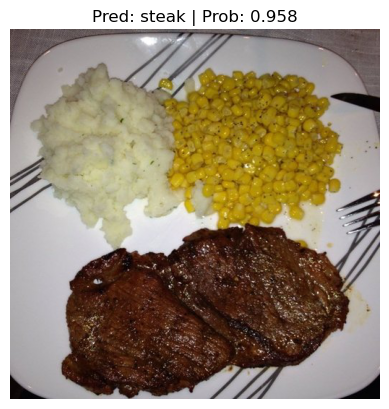

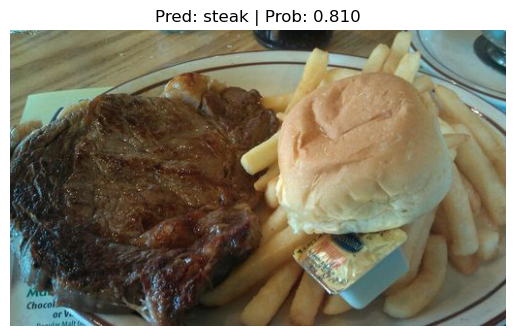

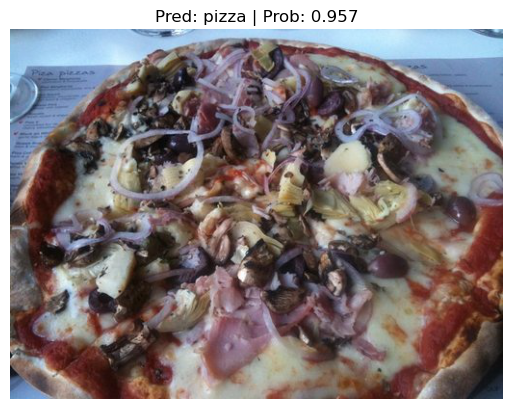

In [97]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from PyTorch_Modular.going_modular.prediction import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        device=device)

### 9.1 Predicting on a custom image with the best model

data\04-pizza-dad.jpeg already exists, skipping download.


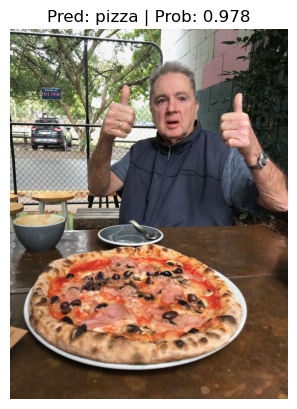

In [99]:
import requests

custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not (custom_image_path.is_file()): 
    with open(custom_image_path, "wb") as f: 
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
        
else: 
    print(f"{custom_image_path} already exists, skipping download.")
    
    
# Predict and plot the custom image
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    device=device)